In [48]:
!pip install pennylane numpy scikit-learn tensorflow qiskit qiskit_aer


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from qiskit.quantum_info import Operator, Statevector
from qiskit import QuantumCircuit
from scipy.linalg import expm
from qiskit_aer import AerSimulator

In [89]:
n_qubits = 4  # 量子比特数
M = 5  # 记忆模式数量（类别）
N = 2 ** n_qubits  # 总状态数
q = 0.2  # 二项分布参数，控制查询状态的汉明距离分布
p_depth = 5  # QAOA电路深度，影响算法精度和计算复杂度
data_mode = 'MNIST'  # 数据模式：'MNIST'使用MNIST，'generated'使用随机模式
steps = 100  # 优化迭代次数，控制参数优化的收敛
# 选择优化器
optimizer_name = "bfgs"  # 可选值："bfgs", "slsqp", "annealing", "nelder-mead"
model = 'C1'  # 模式选择：'C1'或'Ezhov'

In [90]:
def load_mnist_data(M, n_qubits, n_samples_per_class=50):
    """加载并预处理MNIST数据集"""
    # 加载MNIST数据集
    (x_train, y_train), _ = mnist.load_data()
    # 归一化像素值到[0,1]
    x_train = x_train.astype('float32') / 255.0
    # 重塑为1D向量（28x28=784维）
    x_train = x_train.reshape(-1, 28 * 28)
    
    # 选择前M个类别数据
    selected_classes = np.unique(y_train)[:M]  # 前M个类别
    data, labels = [], []
    for cls in selected_classes:
        # 每个类别选取n_samples_per_class个样本
        idx = np.where(y_train == cls)[0][:n_samples_per_class]
        data.append(x_train[idx])
        labels.append([cls] * len(idx))
    data = np.vstack(data)  # 合并数据 [n_samples, 784]
    labels = np.hstack(labels)  # 合并标签 [n_samples]
    
    # 使用PCA将数据降维与量子比特数匹配
    pca = PCA(n_components=n_qubits) 
    features = pca.fit_transform(data) # [n_samples, n_qubits]
    
    # 二值化特征（基于中位数阈值）
    threshold = np.median(features, axis=0)
    binary_patterns = (features > threshold).astype(int) # [n_samples, n_qubits]
    
    # 为每个类别选择一个代表性模式
    memory_states = []
    pattern_to_class = {}
    for cls in selected_classes:
        cls_idx = np.where(labels == cls)[0]
        cls_features = features[cls_idx]  # 当前类别的降维特征
        cls_binary_patterns = binary_patterns[cls_idx]  # 当前类别的二值化模式
        
        # 使用KMeans聚类选择代表性模式
        kmeans = KMeans(n_clusters=1, random_state=42)  # 每个类别聚为1组
        kmeans.fit(cls_features)
        cluster_center = kmeans.cluster_centers_[0]  # 聚类中心
        
        # 找到最接近聚类中心的样本
        closest_idx = np.argmin(np.linalg.norm(cls_features - cluster_center, axis=1))
        pattern = cls_binary_patterns[closest_idx]  # 选择最接近中心的模式
        
        pattern_str = ''.join(map(str, pattern))  # 转换为二进制字符串
        if pattern_str not in memory_states:
            memory_states.append(pattern_str)
            pattern_to_class[pattern_str] = cls  # 记录模式到类别的映射
    

    # 随机从代表性模式中选择一个作为查询中心
    query_pattern = random.sample(memory_states, 1)[0]
    query_class = pattern_to_class[query_pattern]
    idx_0 = np.where(labels == query_class)[0][0]  # 找到对应的样本索引
    query_image = data[idx_0].reshape(28, 28)  # 重塑为28x28以便可视化

    return memory_states, pattern_to_class, query_pattern, query_class, query_image

def generate_random_patterns(n_qubits, M):
    """生成M个随机的二进制模式"""
    # 生成所有可能模式
    all_patterns = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    # 随机选择M个唯一模式
    patterns = random.sample(all_patterns, M)
    # 为每个模式分配伪类别标签（0到M-1）
    pattern_to_class = {p: i for i, p in enumerate(patterns)}
    # 随机选择一个查询中心
    query_pattern = random.choice(all_patterns)
    query_class = None
    query_image = None
    return patterns, pattern_to_class, query_pattern, query_class, query_image  



In [91]:

def format_binary(x):
    """将整数转换为二进制字符串"""
    return format(x, f'0{n_qubits}b')

def hamming_distance(a, b, bin=1):
    if bin != 1:
        a = format_binary(a)
        b = format_binary(b)
    return sum(x != y for x, y in zip(a, b))

def get_distributed_query(query_center, n_qubits, q=0.25):
    """根据二项分布构造分布式查询状态"""
    N = 2 ** n_qubits  # 总状态数
    amplitudes = np.zeros(N)  # 初始化振幅数组
    for x in range(N):
        x_bin = format(x, f'0{n_qubits}b')  # 转换为二进制字符串
        # 计算与查询中心的汉明距离
        hamming_dist = hamming_distance(query_center, x_bin)
        # 根据二项分布设置振幅
        amplitudes[x] = np.sqrt(q ** hamming_dist * (1 - q) ** (n_qubits - hamming_dist))
    # 归一化振幅
    amplitudes /= np.sqrt(np.sum(np.abs(amplitudes) ** 2))
    return amplitudes # 形状为(2^n_qubits,)



# -----------------------
# 构造QAOA算符
# -----------------------
# 实现近似的成本算符 U_C(γ) 和混合算符 U_B(β)

def apply_unitary(qc, gamma, query_state):
    """应用算符 U(γ)"""
    # 应用I+(exp(iγ) - 1)|req><req|
    vector = query_state.reshape(-1, 1)  # 转换为列向量
    # 计算外积
    proj = np.outer(vector, vector.conj())
    H = Operator(proj)  # 创建投影算符
    matrix = expm(1j * gamma * H.data)  # 计算矩阵指数
    qc.unitary(matrix, range(n_qubits), label='U(γ)')
    return qc    



def find_nearest_memory(p, true_memo_ls):
    min_dis = float('inf')
    nearest_memories = []
    # 首先找到最小的汉明距离
    for i in range(len(true_memo_ls)):
        dis =  hamming_distance(p, true_memo_ls[i], bin=1)
        if dis < min_dis:
            min_dis = dis
    
    # 然后收集所有具有最小汉明距离的下标
    print('min_dis:', min_dis)
    for i in range(len(true_memo_ls)):
        dis = hamming_distance(p, true_memo_ls[i], bin=1)
        if dis == min_dis:
            nearest_memories.append(true_memo_ls[i])
    
    return nearest_memories



In [92]:



# 根据data_mode加载或生成数据
if data_mode == 'MNIST':
    memory_states, pattern_to_class, query_center, center_class, query_image = load_mnist_data(M, n_qubits, n_samples_per_class=50)
    print('MNIST真实数据集')

else:
    memory_states, pattern_to_class, query_center, center_class, query_image = generate_random_patterns(n_qubits, M)
    print('随机生成数据集')


print("记忆模式 memory_states：", memory_states)
print("pattern_to_class：", pattern_to_class)
print("查询中心：", query_center)
print("查询中心类别：", center_class)



# 获取查询状态
query_state = get_distributed_query(query_center, n_qubits, q)
print('查询状态：', query_state)
target = find_nearest_memory(query_center, memory_states)
# 归一化目标态
target_state = np.zeros(2**n_qubits)
for t in target:
    idx = int(t, 2)  # 转换为十进制索引
    target_state[idx] = 1 / np.sqrt(len(target))  # 均匀分布

# 初始记忆态振幅分布
memory_state = np.zeros(2**n_qubits)
for m in memory_states:
    idx = int(m, 2)  # 转换为十进制索引
    memory_state[idx] = 1 / np.sqrt(M)  # 均匀分布

# 均匀叠加态 s_state
s_state = np.zeros(2**n_qubits)
for i in range(2**n_qubits):
    s_state[i] = 1 / np.sqrt(N)  # 均匀叠加态

# Global acc
acc_his = []
print('目标态：', target)

# 初始化量子设备
simulator = AerSimulator(method='statevector')  # 使用状态向量模拟器
simulator.set_options(precision='double')

# 构造QAOA电路
def qaoa_circuit(params, memory_state, query_state, n_qubits, p_depth):
    """构造用于VQAM的QAOA电路"""


    # 初始化量子电路
    qc = QuantumCircuit(n_qubits)

    # 初始化记忆态
    initial_state = np.zeros(2**n_qubits, dtype=complex)
    initial_state[:len(memory_state)] = memory_state
    qc.initialize(initial_state, range(n_qubits))

    # 改进算法
    if model == 'C1':
        gamma0 = params[0]
        beta01 = params[1]
        phi = params[2]
        beta02 = params[3]
        gamma = params[4:p_depth+4]
        beta = params[p_depth+4:]
        # Oracle
        apply_unitary(qc, gamma0, target_state) 
        # Diffusion
        apply_unitary(qc, beta01, s_state)
        # Oracle_m
        apply_unitary(qc, phi, memory_state)
        # Diffusion
        apply_unitary(qc, beta02, s_state)
    else:
        gamma = params[:p_depth]  # 成本算符参数
        beta = params[p_depth:]  # 混合算符参数

    # 应用QAOA层
    for k in range(p_depth):
        # 成本算符 U_C(γ)
        apply_unitary(qc, gamma[k], query_state)
        # 混合算符 U_B(β)
        apply_unitary(qc, beta[k], memory_state)

    return qc

def cost_function(params, memory_state, query_state, target, n_qubits, p_depth):
    """计算成本，定义为目标态振幅平方负值，目标态定义为记忆模式中与查询中心最接近的模式"""
    
    qc = qaoa_circuit(params, memory_state, query_state, n_qubits, p_depth)

    probs = Statevector(qc).probabilities()

    target_amplitudes = sum(probs[int(t, 2)] for t in target)
    

    # 存储当前准确率

    acc=float(target_amplitudes)

    cost = 1 - acc    #-np.log(acc + 1e-10)  # 加入小值避免log(0)
    return cost





MNIST真实数据集
记忆模式 memory_states： ['1001', '0011', '1111', '1110', '0100']
pattern_to_class： {'1001': np.uint8(0), '0011': np.uint8(1), '1111': np.uint8(2), '1110': np.uint8(3), '0100': np.uint8(4)}
查询中心： 1001
查询中心类别： 0
查询状态： [0.16 0.32 0.08 0.16 0.08 0.16 0.04 0.08 0.32 0.64 0.16 0.32 0.16 0.32
 0.08 0.16]
min_dis: 0
目标态： ['1001']


In [94]:

def callback_function(params):
    """回调函数，用于动态输出优化过程中的效果"""
    global iteration_count
    iteration_count += 1
    cost = cost_function(params, memory_state, query_state, target, n_qubits, p_depth)
    acc = 1 - cost
    acc_his.append(acc)
    print(f"iter {iteration_count}: cost = {cost:.4f}")

def optimize(optimizer_name, params, memory_state, query_state, target, n_qubits, p_depth, steps):
    """根据用户选择的优化器执行优化"""
    global iteration_count
    iteration_count = 0

    if model == 'C1':
        bounds = [(0, np.pi)] * (2 * p_depth + 4)
    else:
        bounds = [(0, np.pi)] * (2 * p_depth)

    if optimizer_name.lower() == "slsqp":
        result = minimize(
            fun=cost_function,
            x0=params,
            args=(memory_state, query_state, target, n_qubits, p_depth),
            method="SLSQP",
            bounds=bounds,
            callback=callback_function,
            options={"disp": True, "maxiter": steps}
        )
        return result.x

    elif optimizer_name.lower() == "annealing":
        result = dual_annealing(
            func=cost_function,
            bounds=bounds,
            args=(memory_state, query_state, target, n_qubits, p_depth),
            maxiter=steps,
            callback=callback_function,
        )
        return result.x

    elif optimizer_name.lower() == "bfgs":
        result = minimize(
            fun=cost_function,
            x0=params,
            args=(memory_state, query_state, target, n_qubits, p_depth),
            method="L-BFGS-B",
            bounds=bounds,
            callback=callback_function,
            options={"disp": True, "maxiter": steps}
        )
        return result.x

    elif optimizer_name.lower() == "nelder-mead":
        result = minimize(
            fun=cost_function,
            x0=params,
            args=(memory_state, query_state, target, n_qubits, p_depth),
            method="Nelder-Mead",
            callback=callback_function,
            options={"disp": True, "maxiter": steps}
        )
        return result.x

    else:
        raise ValueError("不支持的优化器。请选择 'slsqp', 'annealing', 'bfgs' 或 'nelder-mead'。")

# 初始化参数（γ和β），随机分布在[0, π]
if model == 'Ezhov':
    params = np.random.uniform(0, np.pi, 2 * p_depth)
elif model == 'C1':
    params = np.random.uniform(0, np.pi, 2 * p_depth + 4)

# 执行优化
optimal_params = optimize(optimizer_name, params, memory_state, query_state, target, n_qubits, p_depth, steps)

# 计算最终状态
qc = qaoa_circuit(optimal_params, memory_state, query_state, n_qubits, p_depth)
final_probs = Statevector(qc).probabilities()


states = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]  # 所有可能状态

# 打印记忆模式的概率
for state in memory_states:
    idx = int(state, 2)
    cls = pattern_to_class.get(state, 'N/A')
    print(f"state |{state}⟩ (class {cls})：probability = {final_probs[idx]:.4f}")

iter 1: cost = 0.6342
iter 2: cost = 0.4132
iter 3: cost = 0.3419
iter 4: cost = 0.3274
iter 5: cost = 0.3007
iter 6: cost = 0.2943
iter 7: cost = 0.2924
iter 8: cost = 0.2920
iter 9: cost = 0.2919
iter 10: cost = 0.2918
iter 11: cost = 0.2918
iter 12: cost = 0.2918
iter 13: cost = 0.2918
iter 14: cost = 0.2918
state |1001⟩ (class 0)：probability = 0.7082
state |0011⟩ (class 1)：probability = 0.0210
state |1111⟩ (class 2)：probability = 0.0210
state |1110⟩ (class 3)：probability = 0.0008
state |0100⟩ (class 4)：probability = 0.0008


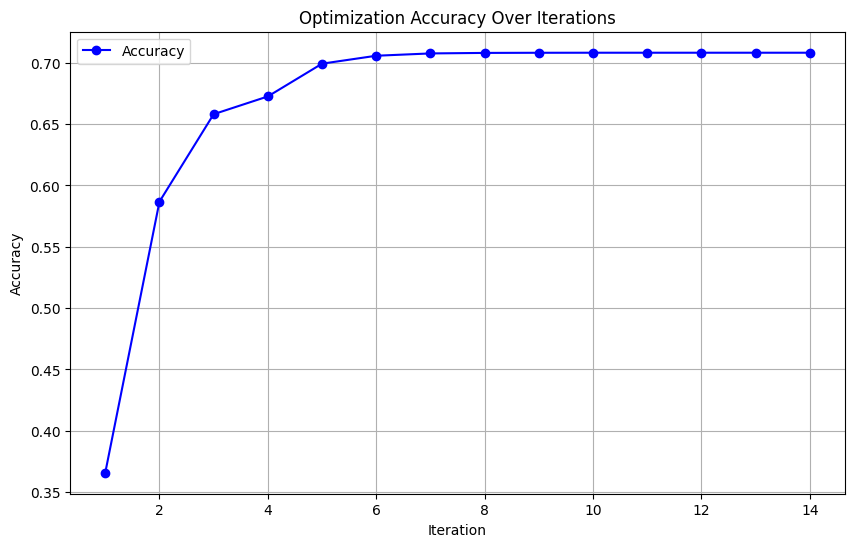

/tmp/ipykernel_2474/816450620.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


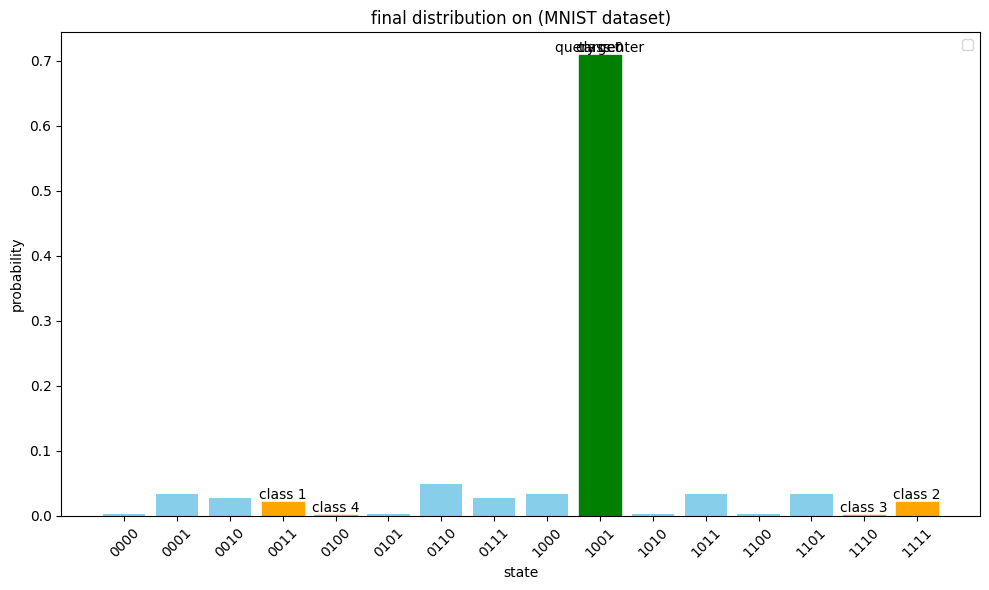

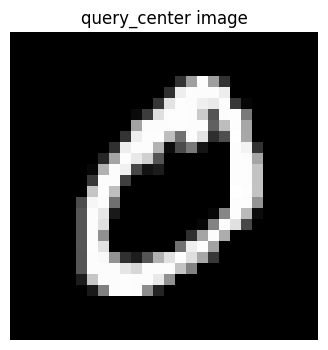

In [95]:
# -----------------------
# 结果可视化
# -----------------------
# 绘制概率分布图，并在MNIST模式下显示查询图像
# 绘制准确率折线图
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(acc_his) + 1), acc_his, marker='o', color='b', label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Optimization Accuracy Over Iterations')
plt.legend()
plt.grid()
plt.show()
# 概率分布图
plt.figure(figsize=(10, 6))
bars = plt.bar(states, final_probs, color='skyblue')  # 柱状图
plt.xlabel('state')
plt.ylabel('probability')
plt.title(f'final distribution on ({data_mode} dataset)')
plt.xticks(rotation=45)  # 旋转x轴标签
plt.legend()

# 高亮记忆模式
for i, state in enumerate(states):
    if state in memory_states:
        bars[i].set_color('orange')  
        cls = pattern_to_class.get(state, 'N/A')
        plt.text(i, final_probs[i], f'class {cls}', ha='center', va='bottom')  # 添加类别标签

# 高亮查询中心
center_idx = states.index(query_center)
bars[center_idx].set_color('red')  # 红色高亮查询中心
plt.text(center_idx, final_probs[center_idx], 'query center', ha='center', va='bottom')  # 添加查询中心标签

# 高亮目标态
for t in target:
    target_idx = states.index(t)
    bars[target_idx].set_color('green')  # 绿色高亮目标态
    plt.text(target_idx, final_probs[target_idx], 'target', ha='center', va='bottom')  # 添加目标态标签

plt.tight_layout()
plt.show()

# 查询图像（仅MNIST模式）
if data_mode == 'MNIST' and query_image is not None:
    plt.figure(figsize=(4, 4))
    plt.imshow(query_image, cmap='gray')  # 显示灰度图像
    plt.title('query_center image')
    plt.axis('off')  # 隐藏坐标轴
    plt.show()


4 4


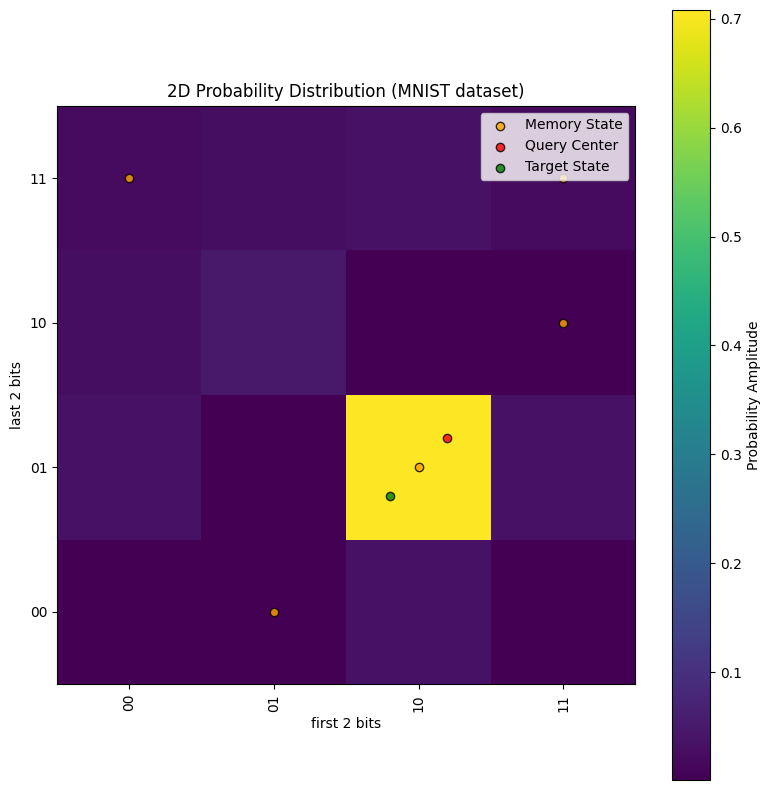

In [96]:
# 将量子态转换为二维坐标
def state_to_coordinates(state, n_qubits):
    """将二进制字符串的量子态转换为二维坐标"""
    x_bits = n_qubits // 2  # x轴的二进制位数
    x = int(state[:x_bits], 2)  # 前x_bits位作为x坐标
    y = int(state[x_bits:], 2)  # 后y_bits位作为y坐标
    return x, y

x_bits = n_qubits // 2 
y_bits = n_qubits - x_bits

# 创建长方形网格
x_size = 2 ** (x_bits)  # x轴大小
y_size = 2 ** (y_bits)  # y轴大小
print(x_size, y_size)
amplitude_grid = np.zeros((x_size, y_size))  # 初始化二维振幅网格

# 填充振幅网格
for i, state in enumerate(states):
    x, y = state_to_coordinates(state, n_qubits)
    if x >= x_size or y >= y_size:
        print(f"Error: Coordinates ({x}, {y}) out of bounds for grid size ({x_size}, {y_size})")
        continue
    amplitude_grid[x, y] = final_probs[i]  # 振幅对应概率

# 绘制二维热力图
plt.figure(figsize=(8, 8))
plt.imshow(amplitude_grid.T, cmap='viridis', origin='lower')  # 使用热力图表示振幅
plt.colorbar(label='Probability Amplitude')  # 添加颜色条
plt.title(f'2D Probability Distribution ({data_mode} dataset)')

# 设置二进制刻度标签
x_labels = [format(i, f'0{x_bits}b') for i in range(x_size)]  # x轴二进制标签
y_labels = [format(i, f'0{y_bits}b') for i in range(y_size)]  # y轴二进制标签
plt.xticks(ticks=range(x_size), labels=x_labels, rotation=90)  # 设置x轴刻度
plt.yticks(ticks=range(y_size), labels=y_labels)  # 设置y轴刻度

plt.xlabel(f'first {x_bits} bits')
plt.ylabel(f'last {y_bits} bits')

# 标出特殊态
offset = 0.2  # 偏移量，用于避免标记重叠

# 绘制记忆态
for state in memory_states:
    x, y = state_to_coordinates(state, n_qubits)
    plt.scatter(x, y, color='orange', label='Memory State', edgecolors='black', alpha=0.8)

# 绘制查询中心
x, y = state_to_coordinates(query_center, n_qubits)
plt.scatter(x + offset, y + offset, color='red', label='Query Center', edgecolors='black', alpha=0.8)  # 偏移标记

# 绘制目标态
for t in target:
    x, y = state_to_coordinates(t, n_qubits)
    plt.scatter(x - offset, y - offset, color='green', label='Target State', edgecolors='black', alpha=0.8)  # 偏移标记

# 添加图例
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # 去重
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

In [97]:
print(len(acc_his))

14


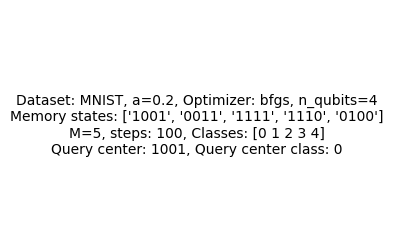

In [98]:

class_array = np.array(list(pattern_to_class.values()), dtype=np.int8)
plt.figure(figsize=(4, 3))
info = f'Dataset: {data_mode}, a={q}, Optimizer: {optimizer_name}, n_qubits={n_qubits}\nMemory states: {memory_states}\nM={M}, steps: {steps}, Classes: {class_array}\nQuery center: {query_center}, Query center class: {center_class}'
plt.text(0.5, 0.5, info, ha='center', va='center')
plt.axis('off')
plt.show()
